# Simpeg 2D inversion Using MTpy-v2 tools

This is an example of how to use MTpy-v2 tools to integrate with Simpeg to build an inversion.  

The recipe in MTpy-v2 is to create a quadree mesh from the given data, then invert the data using computed data errors




In [162]:
import numpy as np

from mtpy import MTCollection
from mtpy.modeling.simpeg.recipes import Simpeg2D

## Load in data

We are going to load in data from a synthetic model that has some northeast trending faults in the upper 5 km.  The data were modeled to be in Australia which is why the EPSG is 4462 (the UTM datum for all of Australia).  The data are already in a profile, but we will demonstrate how to extract a profile line from the data by using the end points (usually in lat, lon).  The data are modeled from 3E-4 to 1E+3.

Steps:

 1) Read in EDI files into an MTData object
 2) Project station locations onto a UTM grid (EPSG = 4462)
 3) Extract the profile
 4) Interpolate onto a common period map
 5) Compute data errors for modeling (usually set an error floor)

### 1) load in data to an MTData object

Here we are taking every third station just to keep the inversion small.  You can change the number to get smaller or bigger data sets to invert.

In [163]:
with MTCollection() as mc:
    mc.open_collection(r"../../data/transfer_functions/forward_profiles.h5")
    other_survey_options = '\n\t'.join(mc.mth5_collection.surveys_group.groups_list)
    mc.working_dataframe = mc.master_dataframe[mc.master_dataframe.survey == "layered_halfspace"]
    md = mc.to_mt_data()

24:10:21T14:26:42 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing ../../data/transfer_functions/forward_profiles.h5


In [164]:
print(f"Other survey options are: \n\t{other_survey_options}")

Other survey options are: 
	conductive_cube
	faults
	layered_halfspace
	ne_conductor
	ne_faults
	near_surface_conductor
	resistive_cube


### 2) Set UTM Grid

In [165]:

md.utm_epsg = 4426

#### 2a) plot stations

24:10:21T14:26:42 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/12/2408/3636


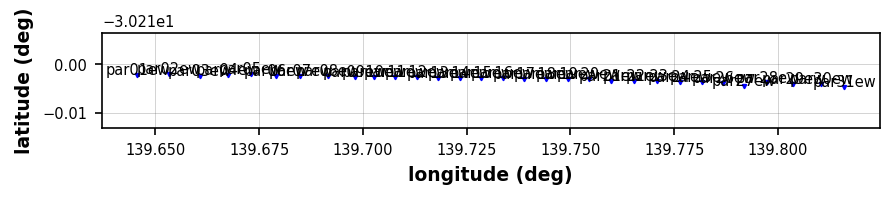

In [166]:

station_plot = md.plot_stations()

### 3) extract profile

This is an example of how to extract a profile from a grid of stations.  You need to know the end points of the profile, usually in (longitude, latitude) and then you can set a distance from that profile line to include station.  

<div class="alert alert-block alert-info">
<b>Note:</b> You should pick your profile line to be approximately perpendicular to geoelectric strike.  To look at geoelectric strike you can use MTData.plot_strike().  See also MTData.generate_profile_from_strike()
</div>

In [167]:

profile = md.get_profile(139.50, -30.211997, 139.9, -30.214724527777776, 5000)

#### 3a) plot profile

Be sure you got all the station you were asking for.  

24:10:21T14:26:45 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/12/2408/3636


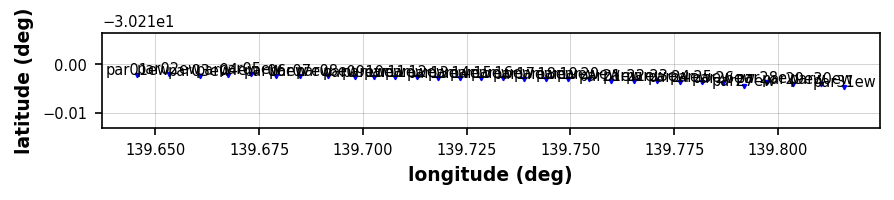

In [168]:

plot_profile = profile.plot_stations()

In [169]:
# 4) Interpolate data onto the same period map
# It is important to use bounds_error=False, which will put Nan where data cannot
# be interpolated. Interpolate onto a period range that keeps the mesh small. 
# decrease the first number to get shorter periods.
profile.interpolate(np.logspace(-1, 3, 5), inplace=True, bounds_error=False)

In [170]:
# 5) set data modeling errors, set an error floor of 5 % for the impedance
profile.z_model_error.error_value = 5
profile.z_model_error.error_type = "percent"
profile.z_model_error

Model Errors:
--------------------
	error_type:    percent
	error_value:   0.05
	floor:         True
	mode:          impedance

In [171]:
profile.compute_model_errors()

## Run 2D inversion

Now use a somewhat standard recipe to invert the data.  User has lots of control of parameters for mesh building, inversion norms, smallness, etc.  This recipe is meant as a convenience object.  For advanced users and those who want to fully understand the Simpeg workflow should build their own recipe.

Here the input data is a Pandas Dataframe.  There is a method in MTData to create a Simpeg Data object.

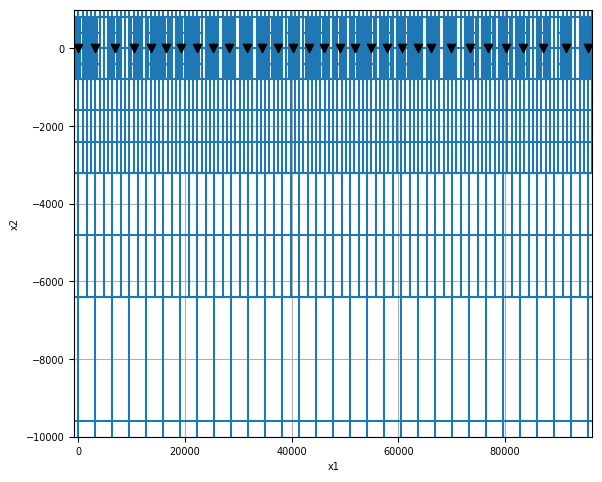

In [172]:
simpeg_2d = Simpeg2D(
    profile.to_dataframe(),
    mesh_kwargs={'factor_spacing':8},
    data_kwargs={},
    max_iterations=10, 
    )

In [173]:
from geoana.em.fdem import skin_depth
import discretize.utils as dis_utils
import discretize
def generate_2d_mesh_for_mt(
    rx_locs, frequencies, sigma_background, 
    z_factor_max=15, 
    z_factor_min=5,
    pfz_down = 1.2,
    pfz_up = 1.5,
    npadz_up = 5,
    x_factor_max = 2,
    spacing_factor = 4,
    pfx = 1.5,
    n_max=1000
):
    # Setting the cells in depth dimension
    f_min = frequencies.min()
    f_max = frequencies.max()
    dz_min = np.round(skin_depth(f_max, sigma_background) / z_factor_max) 
    lz = skin_depth(sigma_background, f_min) * z_factor_max
    # Setting the domain length in z-direction
    for nz_down in range(n_max):
        hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
        if hz_down.sum()>lz:
            break
    hz_up = [(dz_min, npadz_up, pfz_up)]
    hz_up = dis_utils.unpack_widths(hz_up)
    hz = np.r_[hz_down, hz_up]   
    # Setting the cells in lateral dimension
    d_station = np.diff(rx_locs[:,0]).min()
    dx_min = np.round(d_station/spacing_factor)
    lx = rx_locs[:,0].max() - rx_locs[:,0].min()
    ncx = int(lx / dx_min)
    lx_pad = skin_depth(sigma_background, f_min) * x_factor_max
    for npadx in range(n_max):
        hx_pad = dis_utils.unpack_widths([(dx_min, npadx, -pfx)])
        if hx_pad.sum()>lx_pad:
            break
    hx = [(dx_min, npadx, -pfx), (dx_min, ncx), (dx_min, npadx, pfx)]  
    
    mesh = discretize.TensorMesh([hx, hz])
    mesh.origin = np.r_[-mesh.h[0][:npadx].sum()+rx_locs[:,0].min(), -hz_down.sum()]   
    print (mesh)
    return mesh

In [174]:
import matplotlib.pyplot as plt

In [175]:
group = simpeg_2d.data.dataframe.groupby('station')
stations = list(group.groups.keys())

In [176]:
station_locations = simpeg_2d.data.station_locations

In [177]:
rx_locs = station_locations.copy()
frequencies = simpeg_2d.data.frequencies.copy()
# mesh = simpeg_2d.quad_tree.mesh
ind_active = simpeg_2d.active_map.active_cells.copy()

In [178]:
mesh = generate_2d_mesh_for_mt(rx_locs, frequencies, 1e-2)


  TensorMesh: 9,048 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    174   -372,911.17    467,927.17    642.00 124,945.72    1.50
   y     52 -2,790,692.35      2,096.81    106.00 465,203.72    1.50




In [179]:
ind_active = mesh.cell_centers[:,1] < 0.

(-20000.0, 5000.0)

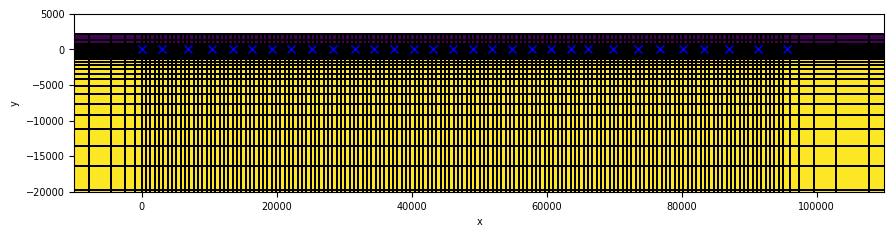

In [180]:
fig, ax = plt.subplots(1,1, figsize=(10, 2))
mesh.plot_image(ind_active, ax=ax, grid=True, grid_opts={'color':'k', 'linewidth':0.1})
ax.plot(station_locations[:,0], station_locations[:,1], 'bx')
plt.xlim(-10000, 1e5+10000)
plt.ylim(-20000, 5000)

In [181]:
simpeg_2d.data.dataframe[['period', 'res_xy', 'phase_xy', 'res_yx', 'phase_yx']]

,period,res_xy,phase_xy,res_yx,phase_yx
0,0.1,6.705109,43.997381,6.705109,-136.002619
1,1.0,10.475062,24.038465,10.475062,-155.961535
2,10.0,43.015748,22.445265,43.015748,-157.554735
3,100.0,106.083053,33.050344,106.083053,-146.949656
4,1000.0,151.262671,40.502218,151.262694,-139.497777
...,...,...,...,...,...
150,0.1,6.705109,43.997381,6.705109,-136.002619
151,1.0,10.475062,24.038465,10.475062,-155.961535
152,10.0,43.015748,22.445265,43.015748,-157.554735
153,100.0,106.083053,33.050344,106.083053,-146.949656


In [182]:
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
from pymatsolver import Pardiso
# simulation class for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

act_map = maps.InjectActiveCells(mesh, ind_active, np.log(1e-8))
exp_map = maps.ExpMap(mesh=mesh)
sigma_map = exp_map * act_map

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

In [183]:
nP = ind_active.sum()
m0 = np.ones(nP) * np.log(1./200.)

(10, 1000)

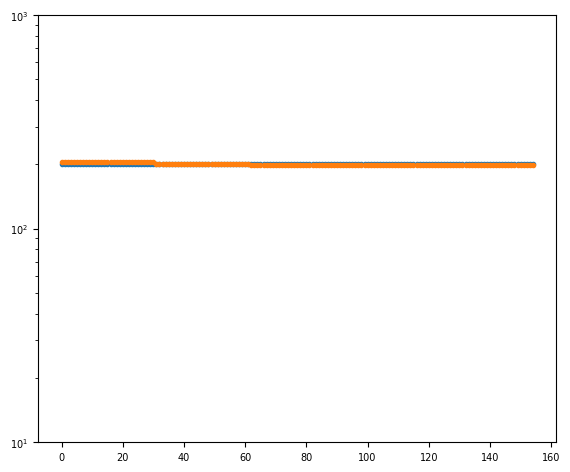

In [184]:
te_pred = sim_te.dpred(m0)
tm_pred = sim_tm.dpred(m0)
TM_PRED = tm_pred.reshape((len(frequencies), 2, 31))
TE_PRED = te_pred.reshape((len(frequencies), 2, 31))
plt.semilogy(TE_PRED[:,0,:].flatten(), '.')
plt.semilogy(TM_PRED[:,0,:].flatten(), '.')
plt.ylim(10, 1000)


(0.0, 90.0)

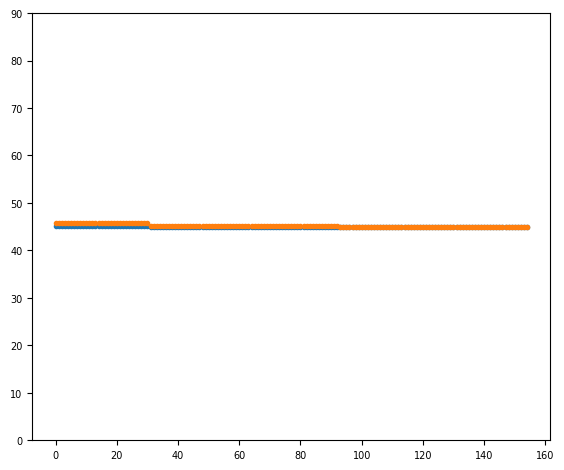

In [185]:
plt.plot(TE_PRED[:,1,:].flatten(), '.')
plt.plot(TM_PRED[:,1,:].flatten()+180., '.')
plt.ylim(0, 90)

In [186]:
dobs_te = simpeg_2d.data.te_data.dobs.copy()
dobs_tm = simpeg_2d.data.tm_data.dobs.copy()
std_te = simpeg_2d.data.te_data_errors.copy()
std_tm = simpeg_2d.data.tm_data_errors.copy()
TE_OBS = dobs_te.reshape((len(frequencies), 2, 31))
TM_OBS = dobs_tm.reshape((len(frequencies), 2, 31))
TE_OBS[:,1,:] = -TE_OBS[:,1,:] + 90.
TM_OBS[:,1,:] = -TM_OBS[:,1,:] - 270
dobs_te = TE_OBS.flatten()
dobs_tm = TM_OBS.flatten()

In [187]:
simpeg_2d.data.dataframe['phase_yx_model_error'] = 5.
simpeg_2d.data.dataframe['phase_xy_model_error'] = 5.

In [188]:
from simpeg import (
    maps, utils, optimization, objective_function, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)

In [189]:
%%time

te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)
dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)
dmis = dmis_te + dmis_tm
alpha_s = 1e-15
alpha_y = 1.
alpha_z = 0.5
maxIter = 10
use_irls = False

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    active_cells=ind_active,
    reference_model=m0,
    alpha_s=alpha_s,
    alpha_x=alpha_y,
    alpha_y=alpha_z,
    mapping=maps.IdentityMap(nP=int(ind_active.sum()))
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=30, tolX=1e-30)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define MT Inversion Directives
# ------------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

if use_irls:
    reg.norms = np.c_[p_s, p_y, p_z]
    # Reach target misfit for L2 solution, then use IRLS until model stops changing.
    IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

    # The directives are defined as a list.
    directives_list = [
        IRLS,
        starting_beta,
        save_dictionary,
    ]
else:
    directives_list = [
        starting_beta,
        beta_schedule,
        save_dictionary,
        # target_misfit,
    ]

    
#####################################################################
# Running the MT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = mt_inversion.run(m0)


Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.33e+01  7.28e+06  0.00e+00  7.28e+06    8.31e+05      0              
   1  1.17e+01  9.43e+05  2.13e-03  9.43e+05    1.09e+05      0              
   2  5.83e+00  1.28e+05  7.90e-03  1.28e+05    1.49e+04      0   Skip BFGS  
   3  2.91e+00  3.21e+04  1.53e-02  3.21e+04    2.14e+03      0   Skip BFGS  
   4  1.46e+00  2.97e+03  1.64e+02  3.21e+03    2.80e+02      0   Skip BFGS  
   5  7.28e-01  8.26e+01  1.14e+02  1.66e+02    6.

In [190]:
survey_te.nD + survey_tm.nD

620

In [191]:
from matplotlib.colors import LogNorm

(-20000.0, 5000.0)

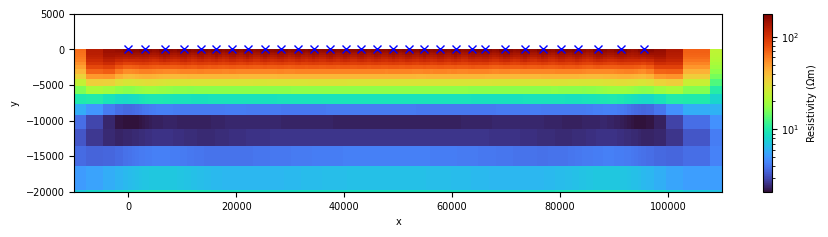

In [192]:
iteration = 9
sigma_est = sigma_map * save_dictionary.outDict[iteration]['m']
dpred = save_dictionary.outDict[iteration]['dpred']
sigma_est[~ind_active] = np.nan

fig, ax = plt.subplots(1,1, figsize=(10, 2))
out = mesh.plot_image(
    1./sigma_est, ax=ax, pcolor_opts={'cmap':'turbo', 'norm':LogNorm()}
)
ax.plot(station_locations[:,0], station_locations[:,1], 'bx')
cb = plt.colorbar(out[0])
cb.set_label("Resistivity ($\Omega$m)")
plt.xlim(-10000, 1e5+10000)
plt.ylim(-20000, 5000)

In [193]:
# te_pred = sim_te.dpred(recovered_conductivity_model)
# tm_pred = sim_tm.dpred(recovered_conductivity_model)

TE_PRED = dpred.reshape((2, len(frequencies), 2, 31))[0,:,:,:]
TM_PRED = dpred.reshape((2, len(frequencies), 2, 31))[1,:,:,:]

In [194]:
TM_OBS = dobs_tm.reshape((len(frequencies), 2, 31))
TE_OBS = dobs_te.reshape((len(frequencies), 2, 31))


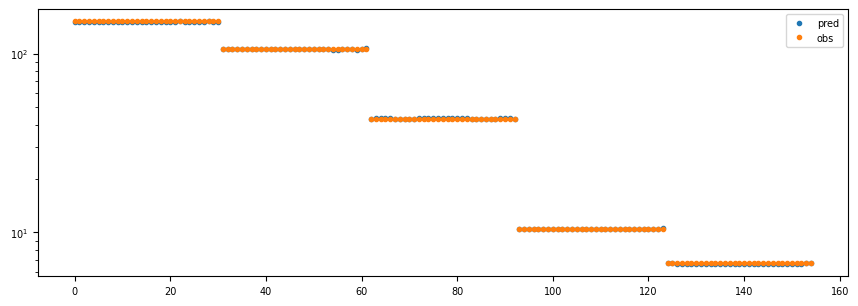

In [195]:
fig = plt.figure(figsize=(10, 3))
plt.semilogy(TE_PRED[:,0,:].flatten(), '.', label='pred')
plt.semilogy(TE_OBS[:,0,:].flatten(), '.', label='obs')
plt.legend()
# plt.ylim(10, 1000)

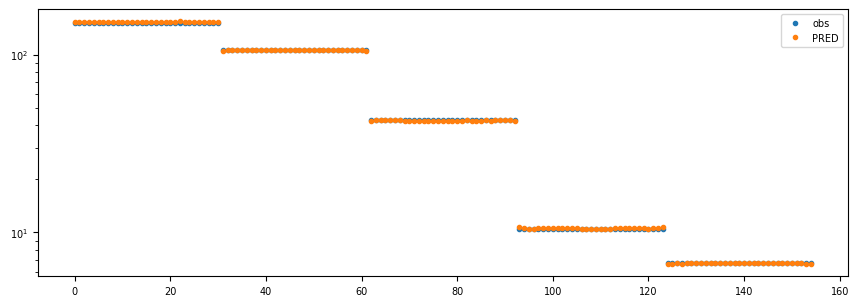

In [196]:
fig = plt.figure(figsize=(10, 3))
plt.semilogy(TM_OBS[:,0,:].flatten(), '.', label='obs')
plt.semilogy(TM_PRED[:,0,:].flatten(), '.', label='PRED')
plt.legend()
# plt.ylim(10, 1000)

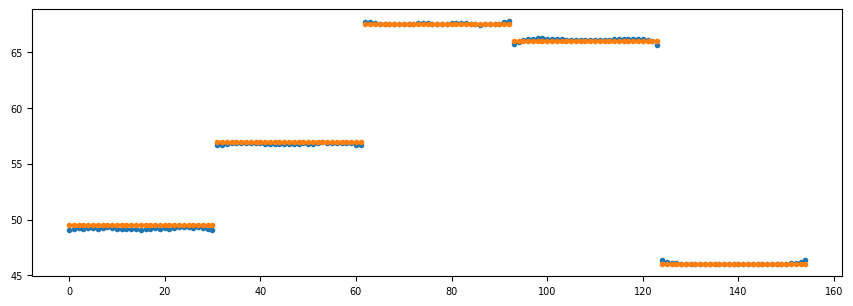

In [197]:
fig = plt.figure(figsize=(10, 3))
plt.plot(TE_PRED[:,1,:].flatten(), '.')
plt.plot(TE_OBS[:,1,:].flatten(), '.')
# plt.ylim(10, 1000)

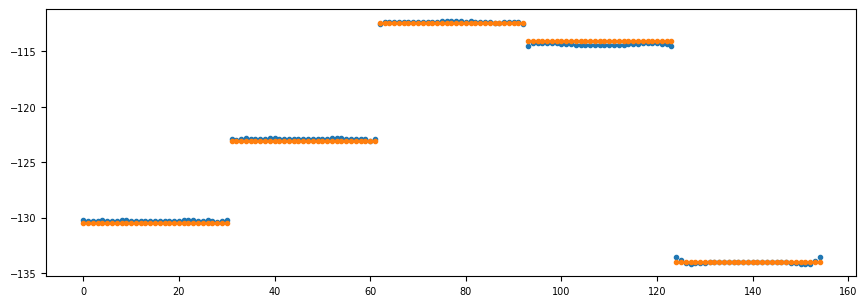

In [198]:
fig = plt.figure(figsize=(10, 3))
plt.plot(TM_PRED[:,1,:].flatten(), '.')
plt.plot(TM_OBS[:,1,:].flatten(), '.')
# plt.ylim(0, 90)

In [199]:
frequencies

array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])